Running simulation with 1 layers...
Number of layers 1
Step 0 out of 100
Step 1 out of 100
Step 2 out of 100
Step 3 out of 100
Step 4 out of 100
Step 5 out of 100
Step 6 out of 100
Step 7 out of 100
Step 8 out of 100
Step 9 out of 100
Step 10 out of 100
Step 11 out of 100
Step 12 out of 100
Step 13 out of 100
Step 14 out of 100
Step 15 out of 100
Step 16 out of 100
Step 17 out of 100
Step 18 out of 100
Step 19 out of 100
Step 20 out of 100
Step 21 out of 100
Step 22 out of 100
Step 23 out of 100
Step 24 out of 100
Step 25 out of 100
Step 26 out of 100
Step 27 out of 100
Step 28 out of 100
Step 29 out of 100
Step 30 out of 100
Step 31 out of 100
Step 32 out of 100
Step 33 out of 100
Step 34 out of 100
Step 35 out of 100
Step 36 out of 100
Step 37 out of 100
Step 38 out of 100
Step 39 out of 100
Step 40 out of 100
Step 41 out of 100
Step 42 out of 100
Step 43 out of 100
Step 44 out of 100
Step 45 out of 100
Step 46 out of 100
Step 47 out of 100
Step 48 out of 100
Step 49 out of 100
Step 

c:\Users\tessa\Documents\GitHub\open-quantum-systems-simulation\.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\tessa\Documents\GitHub\open-quantum-systems-simulation\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


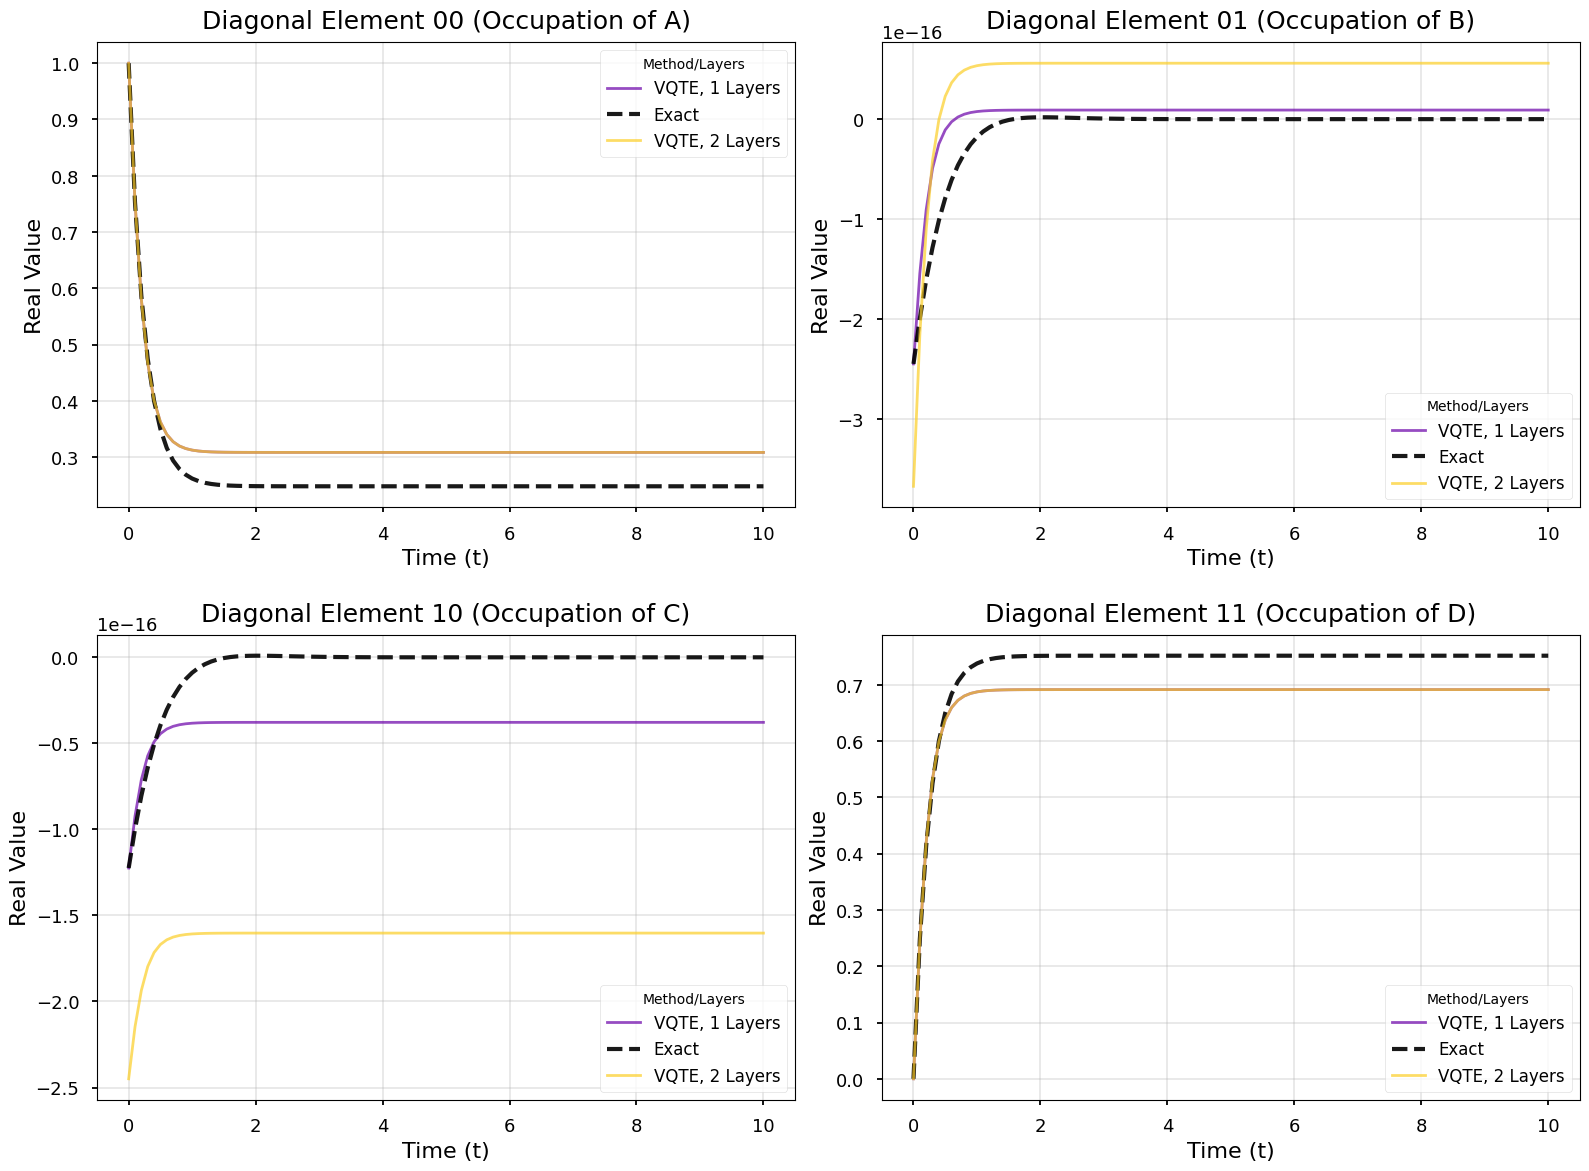

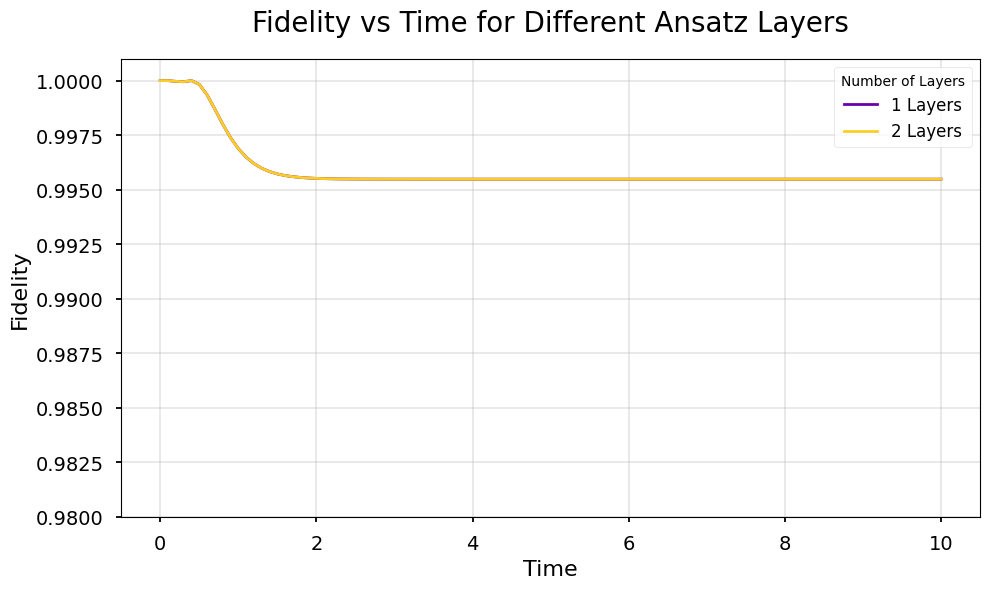

NameError: name 'exact_diag_results' is not defined

In [1]:
# Initialize the simulation parameters
from imports import *
from globalMethods import *
from vqteMethods import *
from exactDiagMethods import *
from fidelity_main import *

layers = 2
time = 10
dt = 0.1
run_multiple_layers(layers, time, dt)


